# Compare station observation and model result profiles


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import glob
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle

%matplotlib notebook

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


#### Load model bathymetry and results

In [4]:
land_color = "#8b7765"

# load bathymetry file:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = mesh.variables['nav_lon']
mesh_lat = mesh.variables['nav_lat']
mesh_bathy = mesh.variables['hdept'][0]
mesh_lon = np.array(mesh_lon)
mesh_lat = np.array(mesh_lat)
mesh_bathy = np.array(mesh_bathy)

In [5]:
def find_index_ANHA12_full(transect_lons, transect_lats, ANHA12_lon=mesh_lon, ANHA12_lat=mesh_lat):
    # input:   ANHA12_lon, ANHA12_lat       --- 2400x1632 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12_lon, ANHA12_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12_lon, ANHA12_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

Sample results

In [6]:
c = nc.Dataset('/data/brogalla/run_storage/riv-base_2019-06-28T154859.121945-0400/'+\
               'ANHA12_EXH006_2002_monthly.nc', 'r')

# Load structure from sample dataset:
lat_model = c.variables['nav_lat']
lon_model = c.variables['nav_lon']
depths_model = c.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

In [7]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

#### Load GEOTRACES data

In [8]:
Mn_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

In [9]:
dMn_BB1 = Mn_data['BB1'].dropna()[1:].astype('float')
dMn_BB2 = Mn_data['BB2'].dropna()[1:].astype('float')
dMn_BB3 = Mn_data['BB3'].dropna()[1:].astype('float')
dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float')
dMn_CB2 = Mn_data['CB2'].dropna()[1:].astype('float')
dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float')
dMn_CB4 = Mn_data['CB4'].dropna()[1:].astype('float')
dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float')
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float')
dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float')
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float')
dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float')
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float')
dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float')
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float')
dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float')

In [10]:
depth_BB1 = Mn_data['Depth.2'].dropna()
depth_BB2 = Mn_data['Depth.3'].dropna()
depth_BB3 = Mn_data['Depth.4'].dropna()
depth_CB1 = Mn_data['Depth.14'].dropna()
depth_CB2 = Mn_data['Depth.15'].dropna()
depth_CB3 = Mn_data['Depth.16'].dropna()
depth_CB4 = Mn_data['Depth.17'].dropna()
depth_CAA1 = Mn_data['Depth.5'].dropna()
depth_CAA2 = Mn_data['Depth.6'].dropna()
depth_CAA3 = Mn_data['Depth.7'].dropna()
depth_CAA4 = Mn_data['Depth.8'].dropna()
depth_CAA5 = Mn_data['Depth.9'].dropna()
depth_CAA6 = Mn_data['Depth.10'].dropna()
depth_CAA7 = Mn_data['Depth.11'].dropna()
depth_CAA8 = Mn_data['Depth.12'].dropna()
depth_CAA9 = Mn_data['Depth.13'].dropna()

In [11]:
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [12]:
profile_colors = ['#ff4949', '#01b9ff']

In [13]:
bottom_depths =[np.amax(d) for d in [depth_CAA1, depth_CAA2, depth_CAA3, depth_CAA4, depth_CAA5, depth_CAA6, \
                            depth_CAA7, depth_CAA8, depth_CAA9, depth_CB1, depth_CB2, depth_CB3]]

In [14]:
mask = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask = mask.variables['tmask']
tmask = np.array(tmask[0,:,:,:])
mlons = mask.variables['nav_lon']
mlats = mask.variables['nav_lat']
mlons = np.array(mlons)
mlats = np.array(mlats)
cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

In [15]:
def station_profile(ax, dMn, stn_depths, name, month, \
                    lons=lons, lats=lats, stn_names=stn_names, depths_model=depths_model):
    ax.invert_yaxis()

    profile_colors = ['#ff4949', '#01b9ff']
      
    # observations:
    dMn_obs   = np.array(dMn)
    depth_obs = np.array(stn_depths)
    ax.plot(dMn_obs, depth_obs, zorder=1, linestyle='-', linewidth=2.5, color=profile_colors[0])
    ax.scatter(dMn_obs, depth_obs, zorder=2, edgecolors='k', color=profile_colors[0])
    
    # model:
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]
    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_i, model_j = find_index_ANHA12_full(lon_station, lat_station)
    model_i = int(model_i); model_j = int(model_j);
    model_stni = int(model_stni); model_stnj = int(model_stnj);
    print(model_i, model_j, model_stni, model_stnj)

    mn_ij1 = mn_dis1[month, 0, :, model_stni, model_stnj]*10**9
    mn_ij2 = mn_dis2[month, 0, :, model_stni, model_stnj]*10**9
    mn_ij3 = mn_dis3[month, 0, :, model_stni, model_stnj]*10**9
    mn_ij1_masked = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), mn_ij1)
    mn_ij2_masked = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), mn_ij2)
    mn_ij3_masked = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), mn_ij3)
    
    ax.plot(mn_ij1_masked, depths_model, zorder=3, linestyle='-', linewidth=1.5, color=profile_colors[1])
    ax.plot(mn_ij2_masked, depths_model, zorder=3, linestyle='--', linewidth=1.5, color=profile_colors[1])
    ax.plot(mn_ij3_masked, depths_model, zorder=3, linestyle='--', linewidth=1.5, color='r')

    ax.set_ylim([depth_obs[-1]+20, -10])
    ax.set_xlim([-2, 15])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([0,5,10,15])
    
    #top patch:
    x0_top     = -10
    y0_top     = -10 - 0.2*depth_obs[-1]
    width_top  = 15+12
    height_top = 0.2*depth_obs[-1]
    box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                      alpha=0.7, zorder=1)
    ax.add_patch(box_top)
    
    #left side patch:
    x0_side     = -10
    y0_side     = -10
    width_side  = 15+12
    height_side = depth_obs[-1]+20+10
    box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, facecolor='w', clip_on=False, \
                                       alpha=0.7, zorder=1)
    ax.add_patch(box_side)
    
    # add name of station to bottom right corner of each profile:
    bottom = depth_obs[-1]+30
    ax.text(6, bottom*0.8, name, fontsize=10)
    
    return

<IPython.core.display.Javascript object>


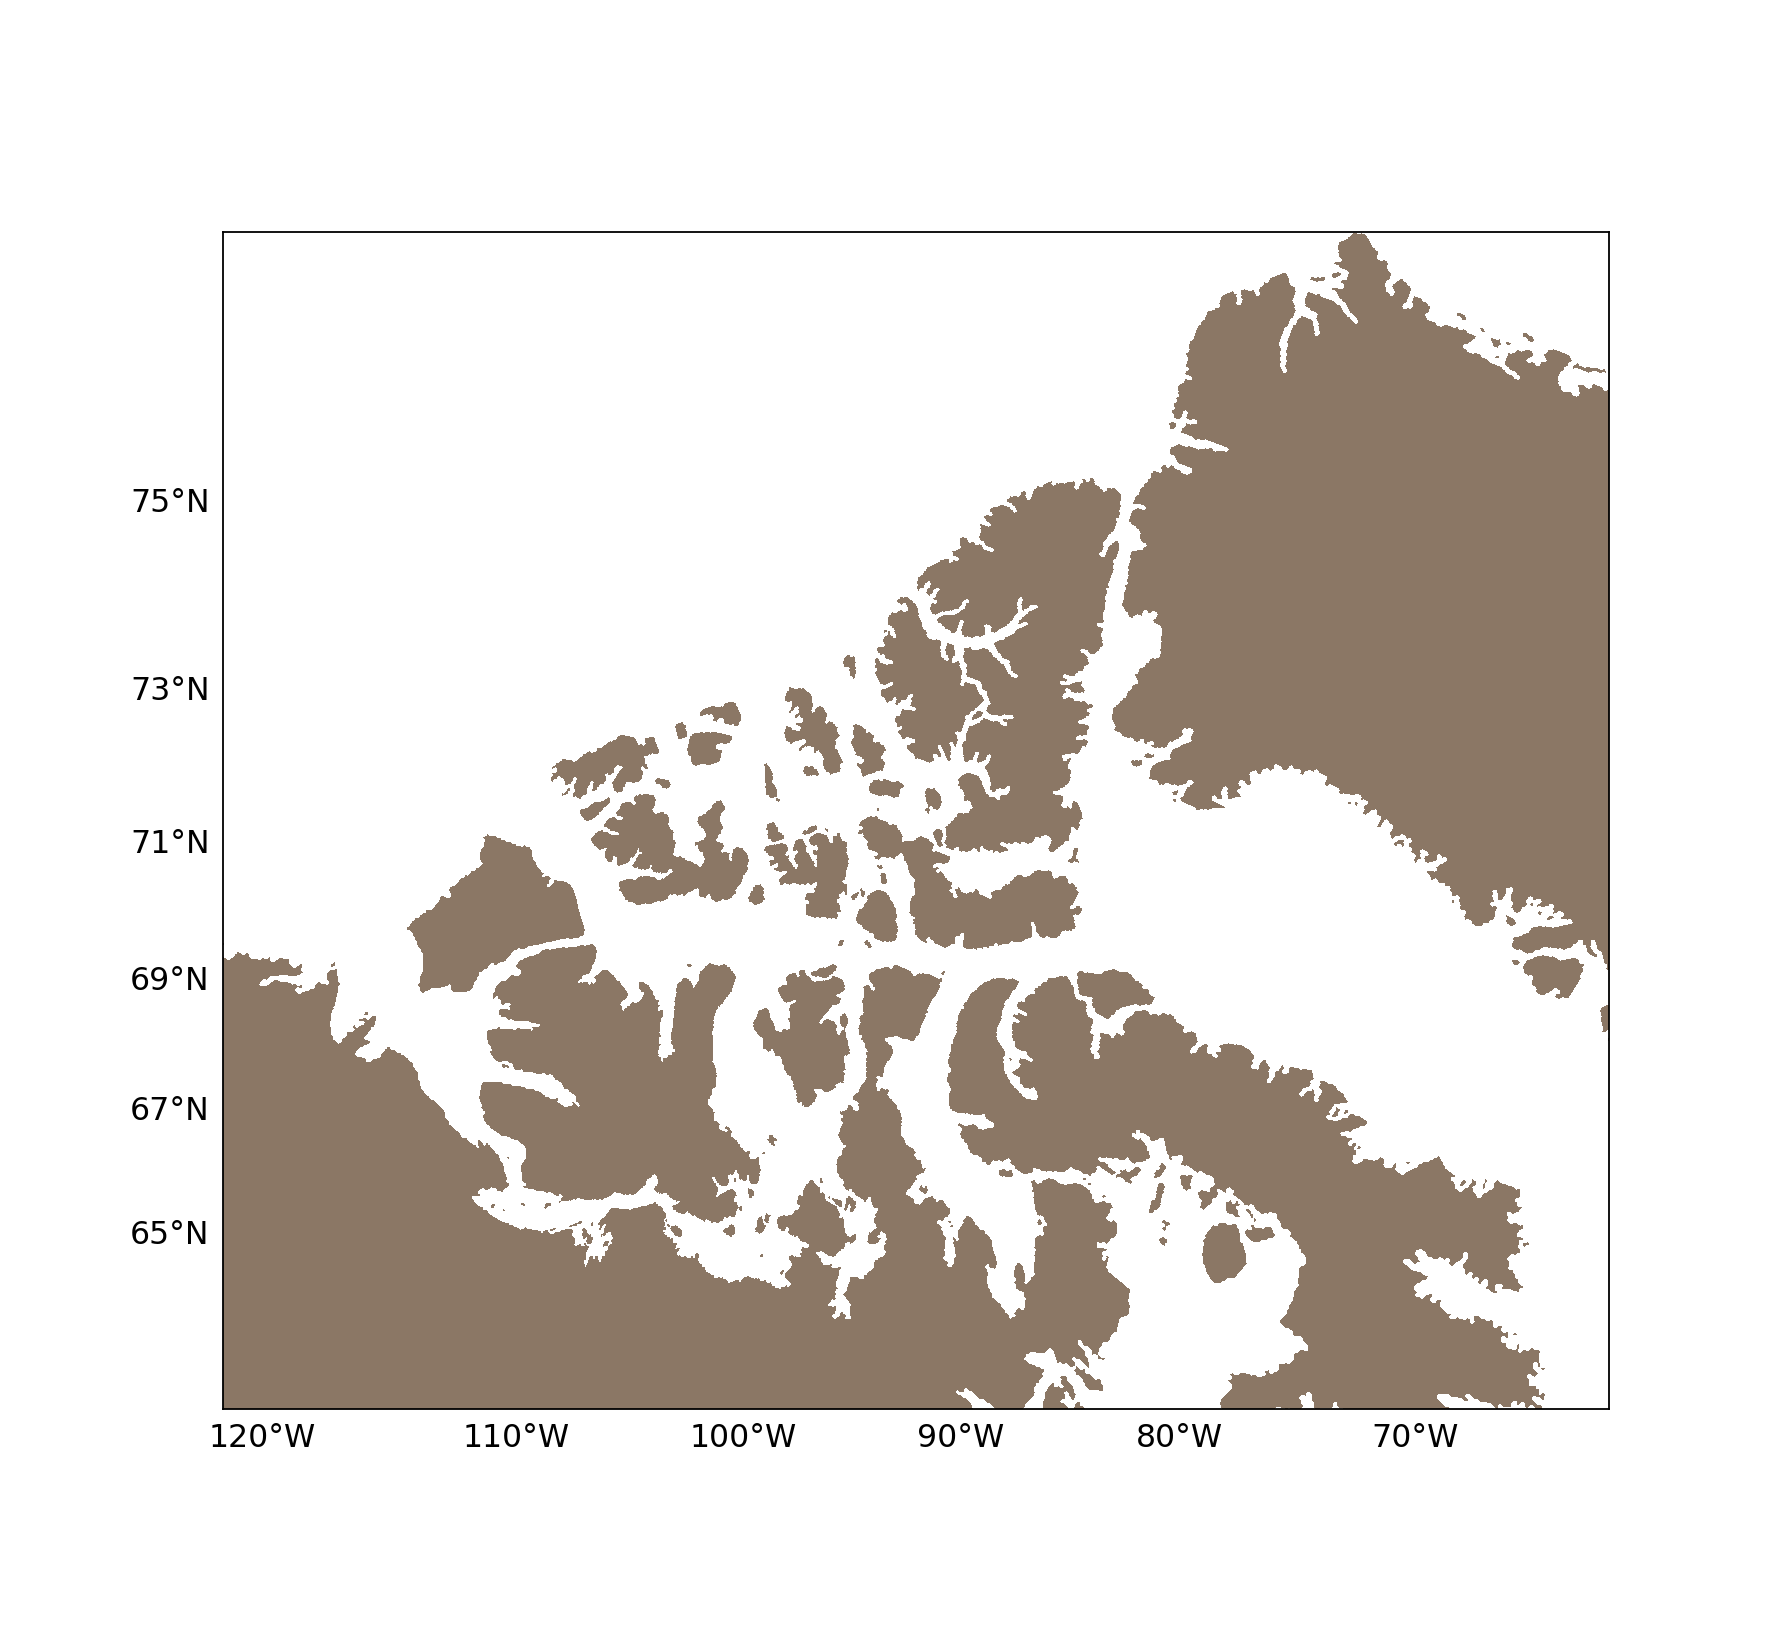

In [16]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn.pickle','rb'))

In [17]:
month=8

In [20]:
#'/data/brogalla/run_storage/sed-cst_2019-08-14T123512.863860-0400/'
end_yr1 = '/data/brogalla/run_storage/sed-cst_2019-08-14T123512.863860-0400/'
end_yr2 = '/data/brogalla/run_storage/sed-cst_2019-08-14T123623.068734-0400/'
end_yr3 = '/data/brogalla/run_storage/sed-cst_2019-08-15T143229.503240-0400/'

file1 = 'ANHA12_EXH006_2002_monthly.nc'
file2 = 'ANHA12_EXH006_2015_monthly.nc'

Mn_model1 = nc.Dataset(end_yr1+file1)
Mn_model2 = nc.Dataset(end_yr2+file1)
Mn_model3 = nc.Dataset(end_yr3+file1)

mn_dis1 = np.array(Mn_model1.variables['dissolmn'])
mn_dis2 = np.array(Mn_model2.variables['dissolmn'])
mn_dis3 = np.array(Mn_model3.variables['dissolmn'])

<IPython.core.display.Javascript object>


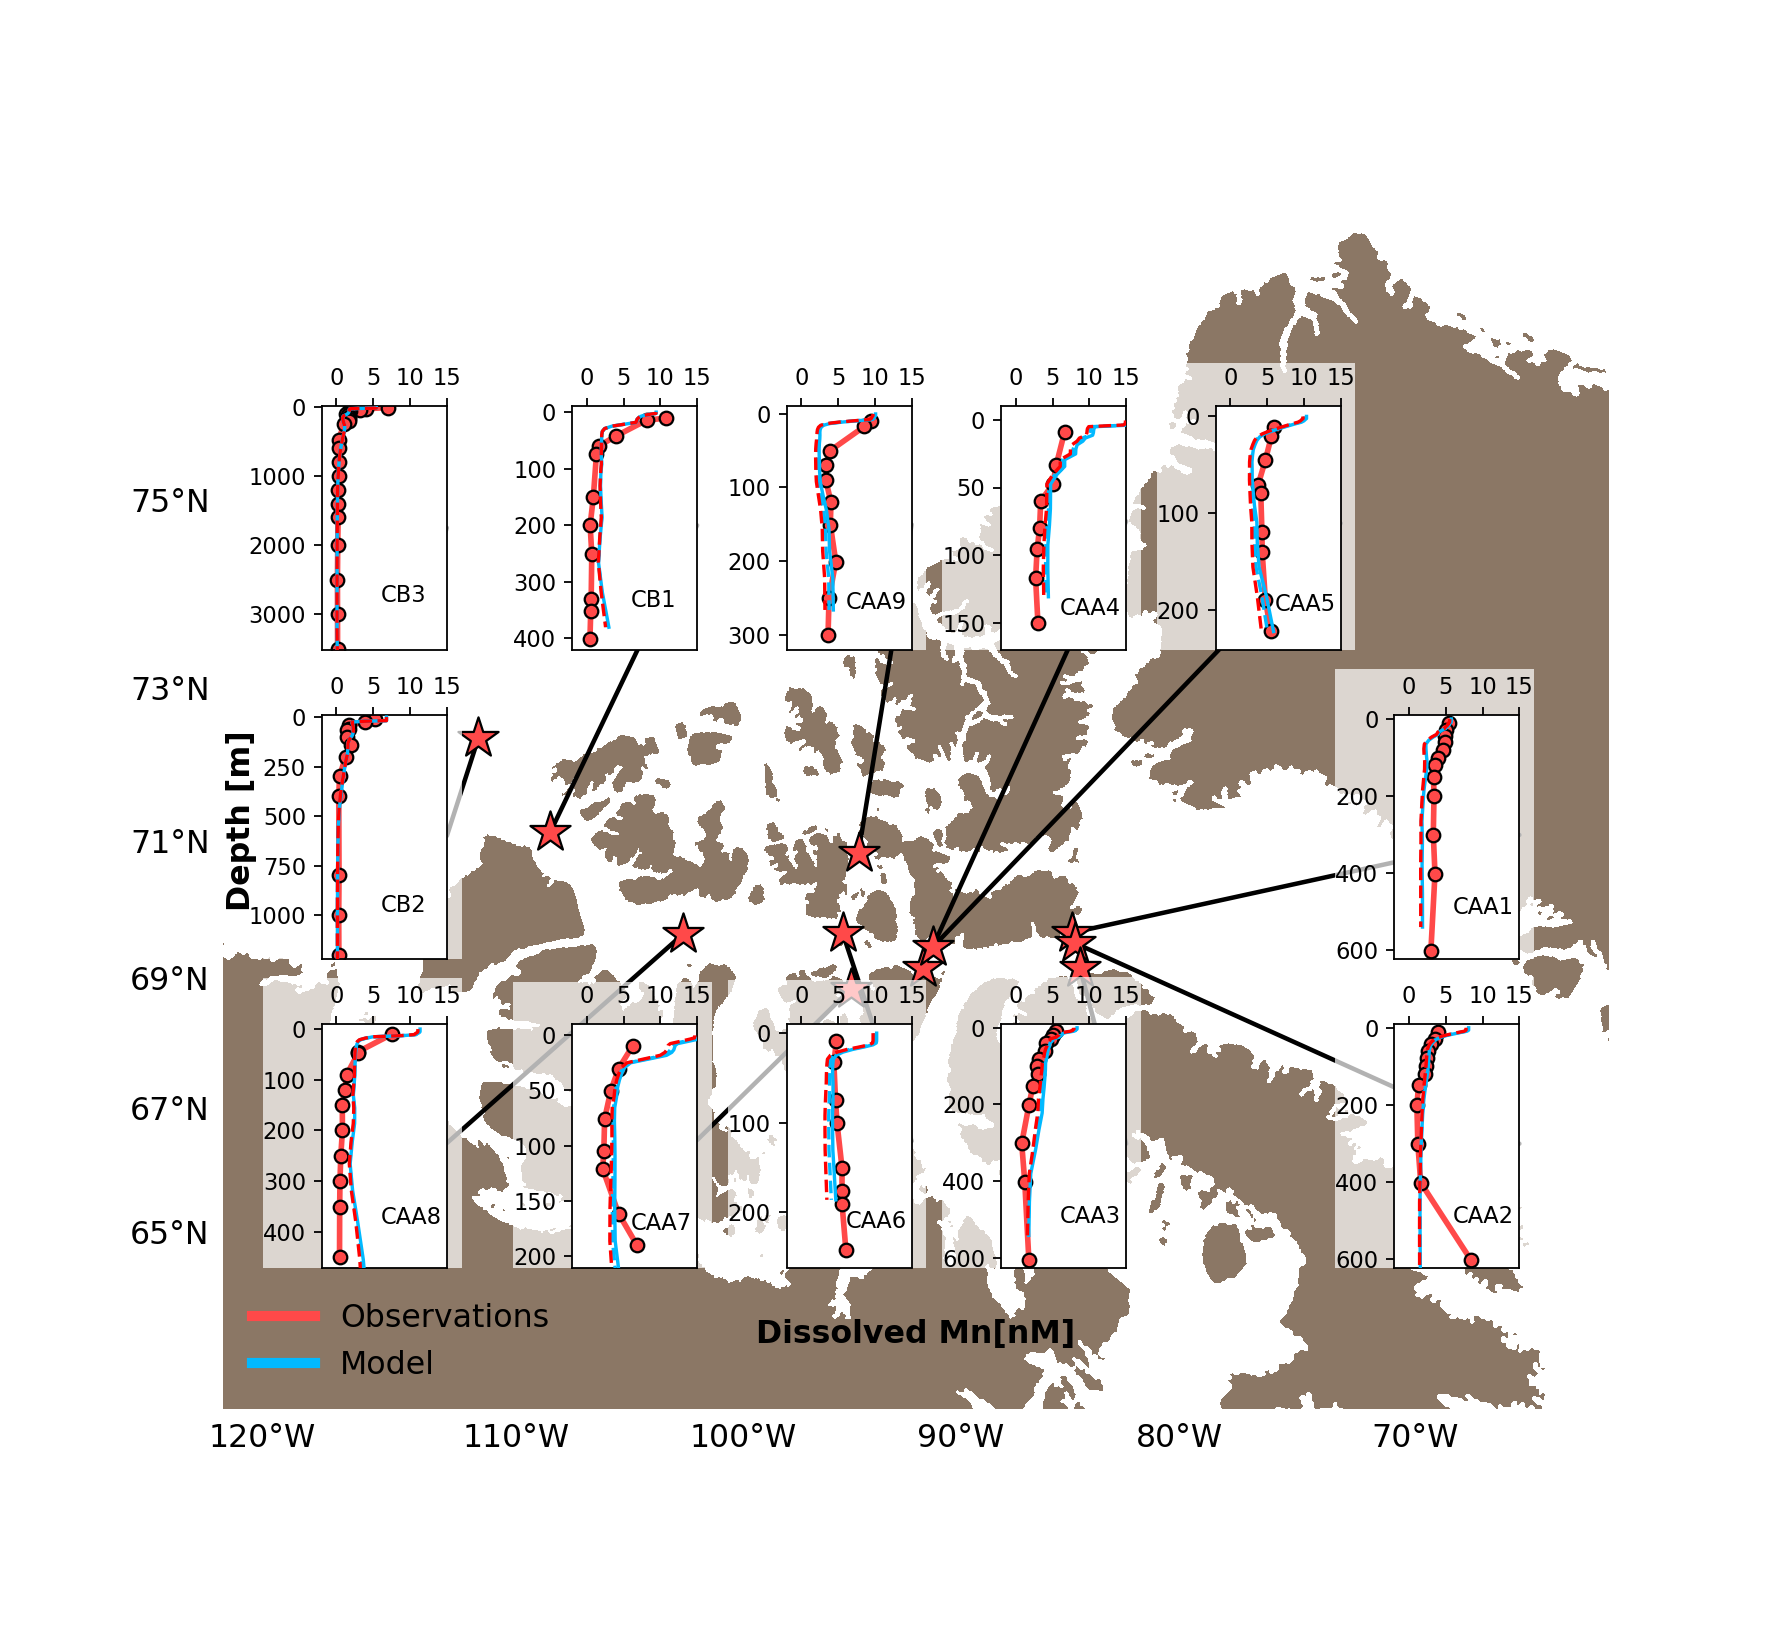

1583 529 104 370
1579 524 100 365
1570 512 91 353
1654 470 175 311
1654 485 175 326
1712 472 233 313
1693 440 214 281
1831 440 352 281
1721 523 242 364
1937 491 458 332
1987 543 508 384
2026 616 547 457


In [21]:
ax   = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn-ax.pickle','rb'))

ax.set_xlabel('Dissolved Mn[nM]', fontsize=14, fontweight='bold', labelpad=-40)
ax.set_ylabel('Depth [m]', fontsize=14, fontweight='bold', labelpad=-15)

# profile plots:
ax1 = plt.axes([0.78, 0.41, 0.07, 0.15]) #CAA1
ax2 = plt.axes([0.78, 0.22, 0.07, 0.15])
ax3 = plt.axes([0.56, 0.22, 0.07, 0.15])
ax4 = plt.axes([0.56, 0.60, 0.07, 0.15])
ax5 = plt.axes([0.68, 0.60, 0.07, 0.15])
ax6 = plt.axes([0.44, 0.22, 0.07, 0.15]) #
ax7 = plt.axes([0.32, 0.22, 0.07, 0.15])
ax8 = plt.axes([0.18, 0.22, 0.07, 0.15])
ax9 = plt.axes([0.44, 0.60, 0.07, 0.15])
ax10 = plt.axes([0.32, 0.60, 0.07, 0.15]) #CB1
ax11 = plt.axes([0.18, 0.41, 0.07, 0.15])
ax12 = plt.axes([0.18, 0.60, 0.07, 0.15])

axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for axi in axes_list:
    axi.tick_params(labelsize=10)
    
fig1 = station_profile(ax1, dMn_CAA1, depth_CAA1, 'CAA1', month)
fig2 = station_profile(ax2, dMn_CAA2, depth_CAA2, 'CAA2', month)
fig3 = station_profile(ax3, dMn_CAA3, depth_CAA3, 'CAA3', month)
fig4 = station_profile(ax4, dMn_CAA4, depth_CAA4, 'CAA4', month)
fig5 = station_profile(ax5, dMn_CAA5, depth_CAA5, 'CAA5', month)
fig6 = station_profile(ax6, dMn_CAA6, depth_CAA6, 'CAA6', month)
fig7 = station_profile(ax7, dMn_CAA7, depth_CAA7, 'CAA7', month)
fig8 = station_profile(ax8, dMn_CAA8, depth_CAA8, 'CAA8', month)
fig9 = station_profile(ax9, dMn_CAA9, depth_CAA9, 'CAA9', month)
fig10 = station_profile(ax10, dMn_CB1, depth_CB1, 'CB1', month)
fig11 = station_profile(ax11, dMn_CB2, depth_CB2, 'CB2', month)
fig12 = station_profile(ax12, dMn_CB3, depth_CB3, 'CB3', month)

x_GEOTRACES, y_GEOTRACES = proj(lons[5:17], lats[5:17]) # leave out CB4, BB and K stations
ax.scatter(x_GEOTRACES, y_GEOTRACES, marker='*',s=350,zorder=5, edgecolor='k', color=profile_colors[0])

# create lines connecting the profiles:
coordsA = "data"
coordsB = "data"
for i in range(len(stn_names[5:17])):
    xy1 = (x_GEOTRACES[i], y_GEOTRACES[i])
    xy2 = (15, bottom_depths[i]/2)
    axB = axes_list[i]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax, axesB=axB, \
                          coordsA=coordsA, coordsB=coordsB, arrowstyle="-", linewidth=2, zorder=2)
    ax.add_artist(con)
    
ax.plot(0, 0, linewidth=4.5, color=profile_colors[0], label="Observations")
ax.plot(0, 0, linewidth=4.5, color=profile_colors[1], label="Model")
ax.legend(fontsize=14, frameon=False, loc=3)
ax.set_frame_on(False)

# plt.savefig('/ocean/brogalla/GEOTRACES/figures/Mn_profile_evaluation-20190815.png', bbox_inches='tight')

# Compare salinity for each of these stations

Salinity is in PSU from "vosaline" output parameter ANHA12; averaged over a month.

In [31]:
dataset = nc.Dataset('/ocean/brogalla/GEOTRACES/data/mean_201509_gridT_vosaline.nc')
S_model = dataset.variables['vosaline']
S_model = np.array(S_model)    

In [37]:
S_obs = pd.read_csv('/ocean/brogalla/GEOTRACES/data/combined_GEOTRACES2015.csv')
S_BB1 = S_obs.loc[S_obs['Station'].astype('str') == 'BB1']['Salinity, Practical [PSU]'].astype(float)
z_BB1 = S_obs.loc[S_obs['Station'].astype('str') == 'BB1']['Depth [salt water, m], lat = 49.00'].astype(float)
S_BB2 = S_obs.loc[S_obs['Station'].astype('str') == 'BB2']['Salinity, Practical [PSU]'].astype(float)
z_BB2 = S_obs.loc[S_obs['Station'].astype('str') == 'BB2']['Depth [salt water, m], lat = 49.00'].astype(float)
S_BB3 = S_obs.loc[S_obs['Station'].astype('str') == 'BB3']['Salinity, Practical [PSU]'].astype(float)
z_BB3 = S_obs.loc[S_obs['Station'].astype('str') == 'BB3']['Depth [salt water, m], lat = 49.00'].astype(float)

S_CB1 = S_obs.loc[S_obs['Station'].astype('str') == 'CB1']['Salinity, Practical [PSU]'].astype(float)
z_CB1 = S_obs.loc[S_obs['Station'].astype('str') == 'CB1']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CB2 = S_obs.loc[S_obs['Station'].astype('str') == 'CB2']['Salinity, Practical [PSU]'].astype(float)
z_CB2 = S_obs.loc[S_obs['Station'].astype('str') == 'CB2']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CB3 = S_obs.loc[S_obs['Station'].astype('str') == 'CB3']['Salinity, Practical [PSU]'].astype(float)
z_CB3 = S_obs.loc[S_obs['Station'].astype('str') == 'CB3']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CB4 = S_obs.loc[S_obs['Station'].astype('str') == 'CB4']['Salinity, Practical [PSU]'].astype(float)
z_CB4 = S_obs.loc[S_obs['Station'].astype('str') == 'CB4']['Depth [salt water, m], lat = 49.00'].astype(float)

S_CAA1 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA1']['Salinity, Practical [PSU]'].astype(float)
z_CAA1 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA1']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA2 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA2']['Salinity, Practical [PSU]'].astype(float)
z_CAA2 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA2']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA3 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA3']['Salinity, Practical [PSU]'].astype(float)
z_CAA3 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA3']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA4 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA4']['Salinity, Practical [PSU]'].astype(float)
z_CAA4 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA4']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA5 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA5']['Salinity, Practical [PSU]'].astype(float)
z_CAA5 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA5']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA6 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA6']['Salinity, Practical [PSU]'].astype(float)
z_CAA6 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA6']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA7 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA7']['Salinity, Practical [PSU]'].astype(float)
z_CAA7 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA7']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA8 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA8']['Salinity, Practical [PSU]'].astype(float)
z_CAA8 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA8']['Depth [salt water, m], lat = 49.00'].astype(float)
S_CAA9 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA9']['Salinity, Practical [PSU]'].astype(float)
z_CAA9 = S_obs.loc[S_obs['Station'].astype('str') == 'CAA9']['Depth [salt water, m], lat = 49.00'].astype(float)

In [69]:
def station_profile_S(ax, name, depth_obs, S_obs, \
                      depths_model=depths_model, S_model=S_model):
    ax.invert_yaxis()

    profile_colors = ['#ff4949', '#01b9ff']
    
    # add name of station to bottom right corner of each profile:
    bottom = np.array(depth_obs)[-1]+30
    ax.text(25, bottom*0.8, name, fontsize=12, fontweight='bold')
    
    # observations:
    ax.plot(S_obs, depth_obs, zorder=2, linestyle='-', linewidth=2.5, color=profile_colors[0])
    
    # model:
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]
    model_i, model_j = find_index_ANHA12_full(lon_station, lat_station)
    model_stni = int(model_i); model_stnj = int(model_j);
    
    ax.plot(S_model[0, :, model_stni, model_stnj][S_model[0, :, model_stni, model_stnj] > 10], \
            depths_model[S_model[0, :, model_stni, model_stnj] > 10], linestyle='--', linewidth=2.5, zorder=3, \
            color=profile_colors[1])#, edgecolors='k')
    
    ax.set_ylim([bottom, -10])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xlim([20,40]) 
    ax.set_xticks([20,30,40])
    
    return

<IPython.core.display.Javascript object>


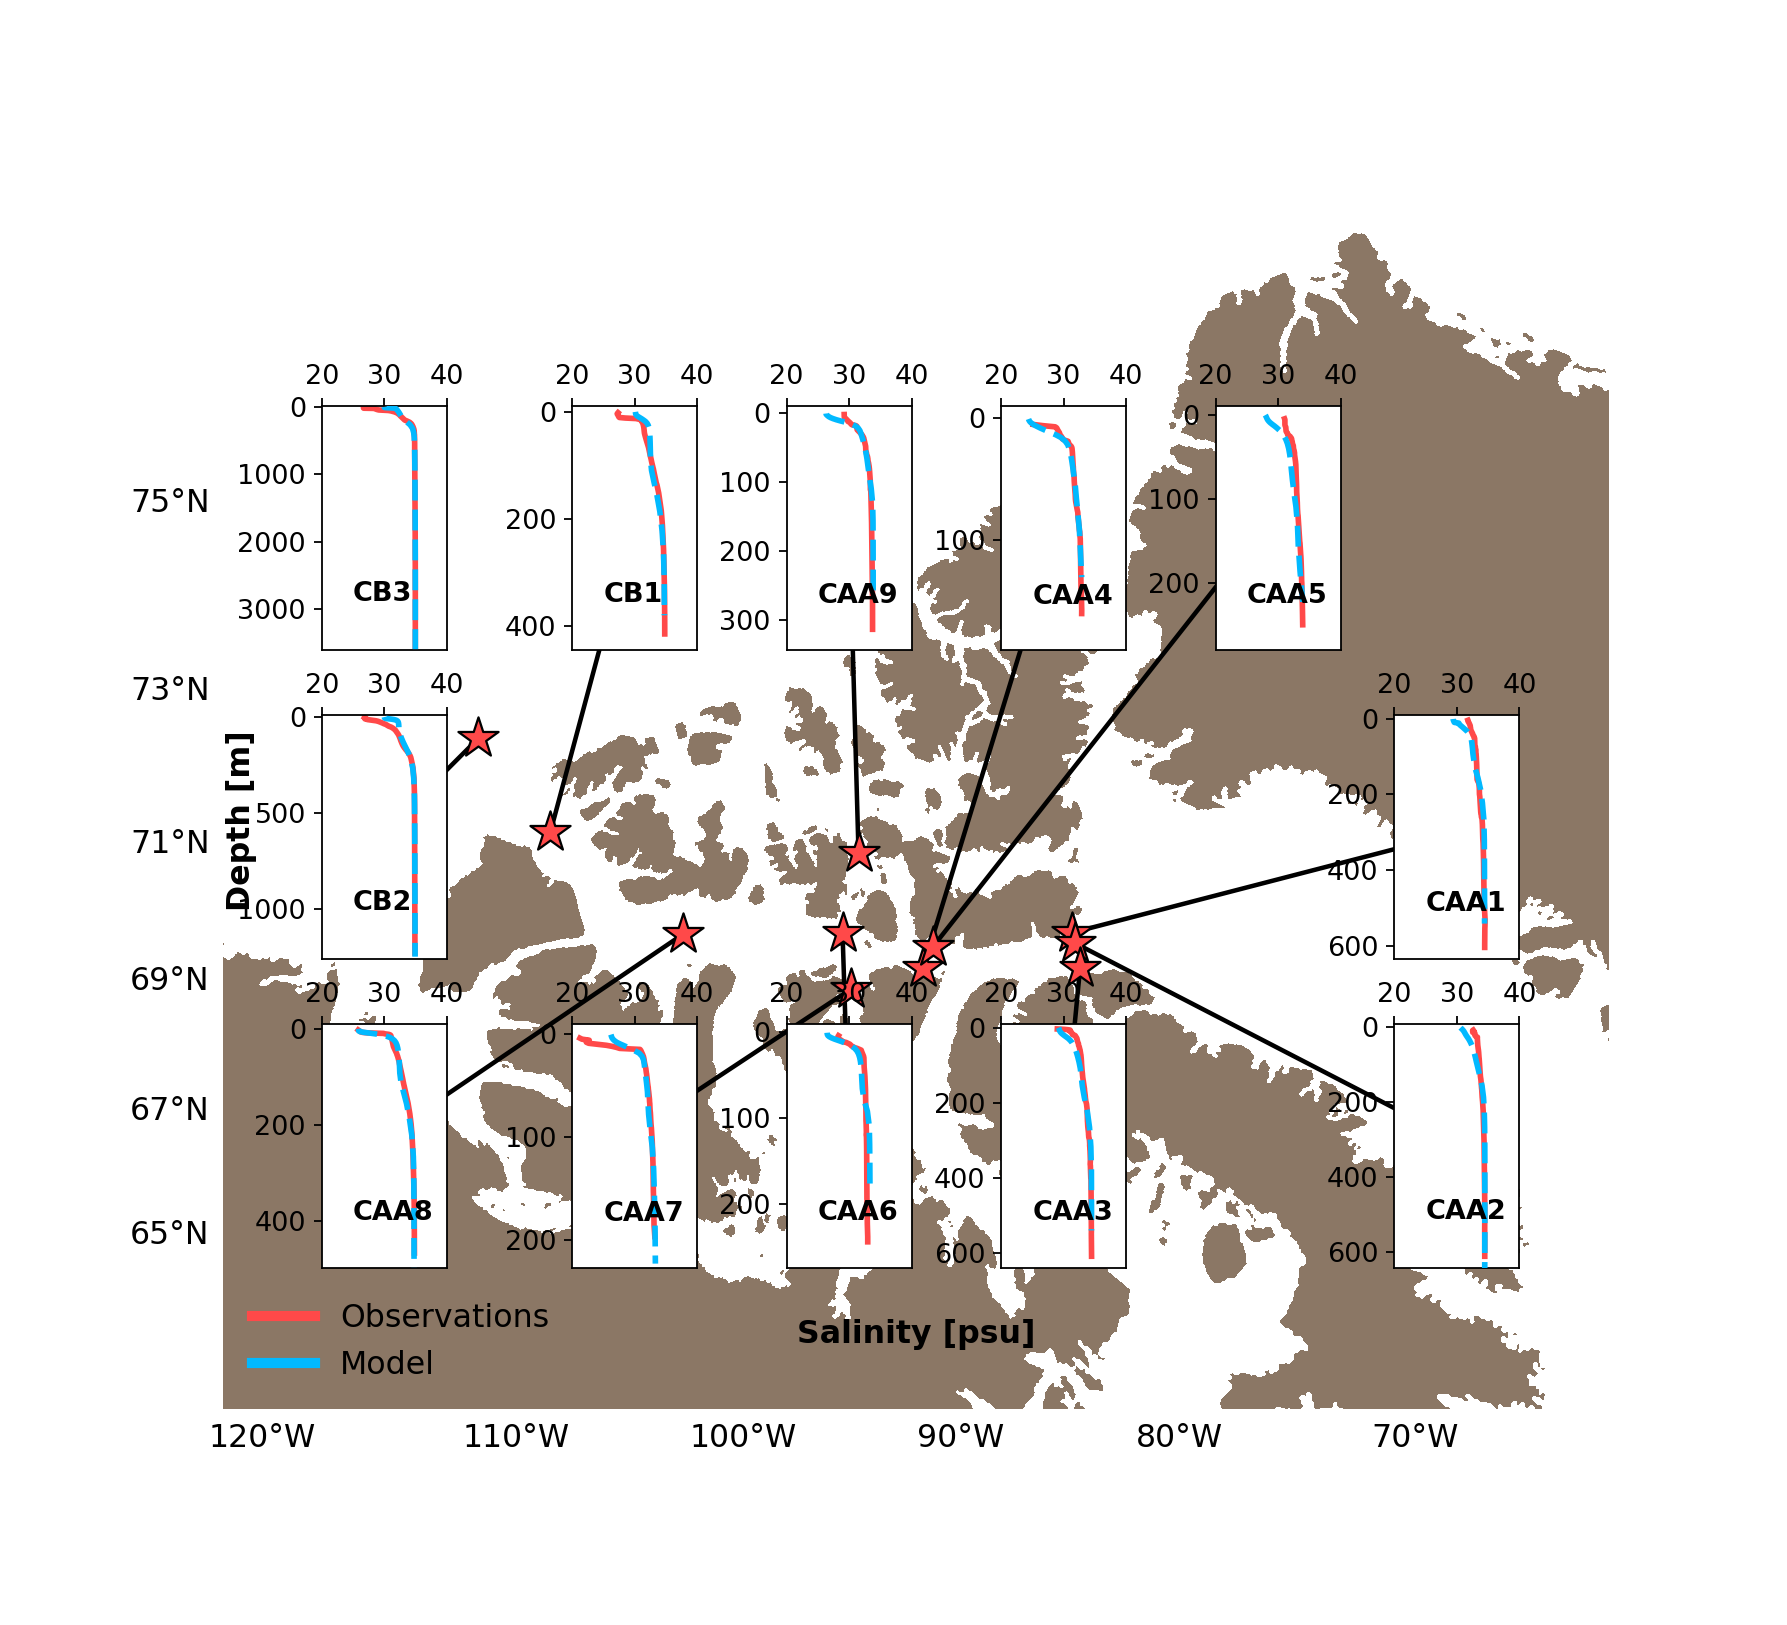

In [72]:
ax   = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn-ax.pickle','rb'))

ax.set_xlabel('Salinity [psu]', fontsize=14, fontweight='bold', labelpad=-40)
ax.set_ylabel('Depth [m]', fontsize=14, fontweight='bold', labelpad=-15)

# profile plots:
axS1 = plt.axes([0.78, 0.41, 0.07, 0.15]) #CAA1
axS2 = plt.axes([0.78, 0.22, 0.07, 0.15])
axS3 = plt.axes([0.56, 0.22, 0.07, 0.15])
axS4 = plt.axes([0.56, 0.60, 0.07, 0.15])
axS5 = plt.axes([0.68, 0.60, 0.07, 0.15])
axS6 = plt.axes([0.44, 0.22, 0.07, 0.15]) #
axS7 = plt.axes([0.32, 0.22, 0.07, 0.15])
axS8 = plt.axes([0.18, 0.22, 0.07, 0.15])
axS9 = plt.axes([0.44, 0.60, 0.07, 0.15])
axS10 = plt.axes([0.32, 0.60, 0.07, 0.15]) #CB1
axS11 = plt.axes([0.18, 0.41, 0.07, 0.15])
axS12 = plt.axes([0.18, 0.60, 0.07, 0.15])

axesS_list=[axS1, axS2, axS3, axS4, axS5, axS6, axS7, axS8, axS9, axS10, axS11, axS12]

for axi in axesS_list:
    axi.tick_params(labelsize=12)

fig1 = station_profile_S(axS1, 'CAA1', z_CAA1, S_CAA1)
fig2 = station_profile_S(axS2, 'CAA2', z_CAA2, S_CAA2)
fig3 = station_profile_S(axS3, 'CAA3', z_CAA3, S_CAA3)
fig4 = station_profile_S(axS4, 'CAA4', z_CAA4, S_CAA4)
fig5 = station_profile_S(axS5, 'CAA5', z_CAA5, S_CAA5)
fig6 = station_profile_S(axS6, 'CAA6', z_CAA6, S_CAA6)
fig7 = station_profile_S(axS7, 'CAA7', z_CAA7, S_CAA7)
fig8 = station_profile_S(axS8, 'CAA8', z_CAA8, S_CAA8)
fig9 = station_profile_S(axS9, 'CAA9', z_CAA9, S_CAA9)
fig10 = station_profile_S(axS10, 'CB1', z_CB1, S_CB1)
fig11 = station_profile_S(axS11, 'CB2', z_CB2, S_CB2)
fig12 = station_profile_S(axS12, 'CB3', z_CB3, S_CB3)

x_GEOTRACES, y_GEOTRACES = proj(lons[5:17], lats[5:17]) # leave out CB4, BB and K stations
ax.scatter(x_GEOTRACES, y_GEOTRACES, marker='*',s=350,zorder=5, edgecolor='k', color=profile_colors[0])

# create lines connecting the profiles:
coordsA = "data"
coordsB = "data"
for i in range(len(stn_names[5:17])):
    xy1 = (x_GEOTRACES[i], y_GEOTRACES[i])
    xy2 = (30, bottom_depths[i]/2)
    axB = axesS_list[i]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax, axesB=axB, \
                          coordsA=coordsA, coordsB=coordsB, arrowstyle="-", linewidth=2, zorder=2)
    ax.add_artist(con)
    
ax.plot(0, 0, linewidth=4.5, color=profile_colors[0], label="Observations")
ax.plot(0, 0, linewidth=4.5, color=profile_colors[1], label="Model")
ax.legend(fontsize=14, frameon=False, loc=3)
ax.set_frame_on(False)

plt.savefig('/ocean/brogalla/GEOTRACES/figures/S_profile_evaluation.png', bbox_inches='tight')

# Side by side profile comparisons:

Note that I did not convert the CAA salinity stations' pressure to depth.

Surface values of dissolved Mn appear to be underestimated by the model. I compare these profiles with the modelled salinity profiles, to see if this is due to insufficient influence of river water near the surface in the model. Below are the plotted modelled and measured values.

In [129]:
def plot_S_dMn(ax, dMn, depth_obs, name, stn_obj, stn_depth=stn_depth, stn_sali=stn_sali, \
                      depths_model=depths_model, S_model=S_model):
    month = 9
    
    variable_colors = ['#ec8a04', '#247896'] # Salinity, dMn
    
    ax.set_title(name, fontweight='bold')
    ax.invert_yaxis()
    ax.set_ylim([120, -2])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('bottom') 
    ax.set_xticks([24, 28, 32, 36])
    ax.set_xlim([21,36])
    ax2 = ax.twiny()  
    ax2.set_xlim([0, 15])
    ax2.set_xticks([0, 5, 10, 15])
    
    ax.spines['bottom'].set_color(variable_colors[0])
    ax.spines['top'].set_color(variable_colors[1])
    ax.tick_params(axis='x', colors=variable_colors[0])
    ax2.tick_params(axis='x', colors=variable_colors[1])

    # observations:
    # Salinity:
    S_obs     = np.array(stn_sali[stn_name==name])
    depthS_obs = np.array(stn_depth[stn_name==name])
    ax.scatter(S_obs[::10], depthS_obs[::10], color=variable_colors[0], zorder=3, edgecolor='k') 
    # dMn:
    dMn_obs   = np.array(dMn)
    depth_obs = np.array(depth_obs)
    ax2.scatter(dMn_obs, depth_obs, color=variable_colors[1], zorder=3, edgecolor='k')

    # model:
    # Salinity:
    model_stni, model_stnj = find_index_ANHA12_full(stn_obj.lon, stn_obj.lat)
    ax.plot(S_model[0, :, model_stni, model_stnj], depths_model, \
                linestyle='-', linewidth=3, color=variable_colors[0])
    # dMn:
    model_stni, model_stnj = find_index_ANHA12_sub(stn_obj.lon, stn_obj.lat)
    ax2.plot(mn_dis[month, :, model_stni, model_stnj]*10**9, depths_model, zorder=1, \
                linestyle='-', linewidth=3, color=variable_colors[1])
    return ax

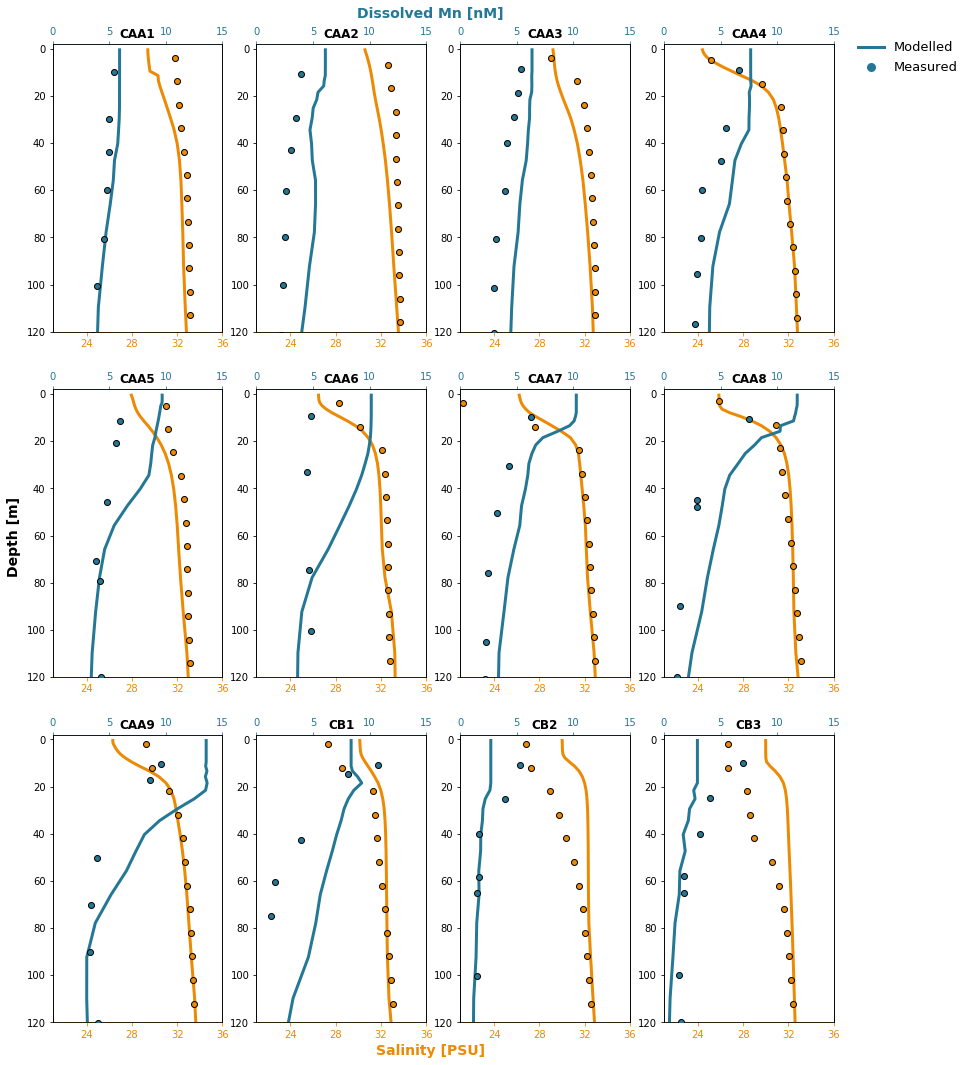

In [130]:
fig, ax = plt.subplots(3,4,figsize=(14, 18))

variable_colors = ['#ec8a04', '#247896'] # Salinity, dMn
fig.text(0.5, 0.10, 'Salinity [PSU]', ha='center', fontsize=14, color=variable_colors[0],fontweight='bold')
fig.text(0.5, 0.90, 'Dissolved Mn [nM]', ha='center', fontsize=14, color=variable_colors[1], fontweight='bold')
fig.text(0.08, 0.5, 'Depth [m]', va='center', rotation='vertical', fontsize=14, fontweight='bold')

ax[0,3].plot([0,0],[0,0], label='Modelled', linewidth=3, color=variable_colors[1])
ax[0,3].scatter([0,0],[0,0], label='Measured', linewidth=3, color=variable_colors[1])
ax[0,3].legend(bbox_to_anchor=(1.8, 1.05), fontsize=13, frameon=False)

ax1 = plot_S_dMn(ax[0,0], dMn_CAA1, depth_CAA1, 'CAA1', CAA1)
ax2 = plot_S_dMn(ax[0,1], dMn_CAA2, depth_CAA2, 'CAA2', CAA2)
ax3 = plot_S_dMn(ax[0,2], dMn_CAA3, depth_CAA3, 'CAA3', CAA3)
ax4 = plot_S_dMn(ax[0,3], dMn_CAA4, depth_CAA4, 'CAA4', CAA4)
ax5 = plot_S_dMn(ax[1,0], dMn_CAA5, depth_CAA5, 'CAA5', CAA5)
ax6 = plot_S_dMn(ax[1,1], dMn_CAA6, depth_CAA6, 'CAA6', CAA6)
ax7 = plot_S_dMn(ax[1,2], dMn_CAA7, depth_CAA7, 'CAA7', CAA7)
ax8 = plot_S_dMn(ax[1,3], dMn_CAA8, depth_CAA8, 'CAA8', CAA8)
ax9 = plot_S_dMn(ax[2,0], dMn_CAA9, depth_CAA9, 'CAA9', CAA9)
ax10 = plot_S_dMn(ax[2,1], dMn_CB1, depth_CB1, 'CB1', CB1)
ax11 = plot_S_dMn(ax[2,2], dMn_CB2, depth_CB2, 'CB2', CB2)
ax12 = plot_S_dMn(ax[2,3], dMn_CB3, depth_CB3, 'CB3', CB3)

Difference between the modelled and observed salinity and Mn, plotted on the same axes. Calculated by finding the model point closest in depth to an observation depth point and subtracting the observed value from the modelled value. Positive difference means that the model overpredicts the value, while negative means it underpredicts the value. In some places there seems to be anti-correlation, but the reason for the strong deviation of the model with the observations at CAA4 is still unclear; CB2 is a good illustration of what I expected.

In [138]:
def plot_S_dMn_diff(ax, dMn, depth_obs, name, stn_obj, stn_depth=stn_depth, stn_sali=stn_sali, \
                      depths_model=depths_model, S_model=S_model):
    month = 9
    ymax  = 175
    
    variable_colors = ['#ec8a04', '#247896'] # Salinity, dMn
    
    ax.set_title(name, fontweight='bold')
    ax.invert_yaxis()
    ax.set_ylim([ymax, -2])
    ax.xaxis.tick_top() 
    ax.set_xticks([])
#     ax.xaxis.set_label_position('bottom') 
    ax.set_xlim([-5,5])
    ax2 = ax.twiny()  
    ax2.set_xlim([-5, 5])
    ax2.set_xticks([-4, -2, 2, 4])

    # Load data:
    # Salinity:
    modelS_stni, modelS_stnj = find_index_ANHA12_full(stn_obj.lon, stn_obj.lat)
    sal_model   = S_model[0, :, modelS_stni, modelS_stnj]
    S_obs       = np.array(stn_sali[stn_name==name])
    depthS_obs  = np.array(stn_depth[stn_name==name])
    # dMn:
    model_stni, model_stnj = find_index_ANHA12_sub(stn_obj.lon, stn_obj.lat)
    dMn_model   = mn_dis[month, :, model_stni, model_stnj]*10**9
    depthMn_obs = np.array(depth_obs)
    dMn_obs     = np.array(dMn)
    
    # Calculate difference between obs and model:
    i=0
    diff_sal=np.zeros(depths_model.shape)
    for depth in depths_model:
        ind = np.argmin(np.abs(depth-depthS_obs)) # index of observed element closest to model
        diff_sal[i] = sal_model[i]-S_obs[ind]
        i+=1
    
    j=0
    diff_dmn=np.zeros(depthMn_obs.shape)
    for depth in depthMn_obs:
        ind = np.argmin(np.abs(depths_model-depth)) # index of model element closest to observe depth
        diff_dmn[j] = dMn_model[ind]-dMn_obs[j]
        j+=1       
    
    ax.plot(   diff_sal , depths_model , color=variable_colors[0], zorder=3)
    ax.scatter(diff_sal , depths_model , color=variable_colors[0], zorder=3, edgecolor='k') 
    ax2.plot(   diff_dmn, depthMn_obs, color=variable_colors[1], zorder=3)
    ax2.scatter(diff_dmn, depthMn_obs, color=variable_colors[1], zorder=3, edgecolor='k')
    ax.plot([0, 0], [ymax, -2], '--k')
    
    return ax

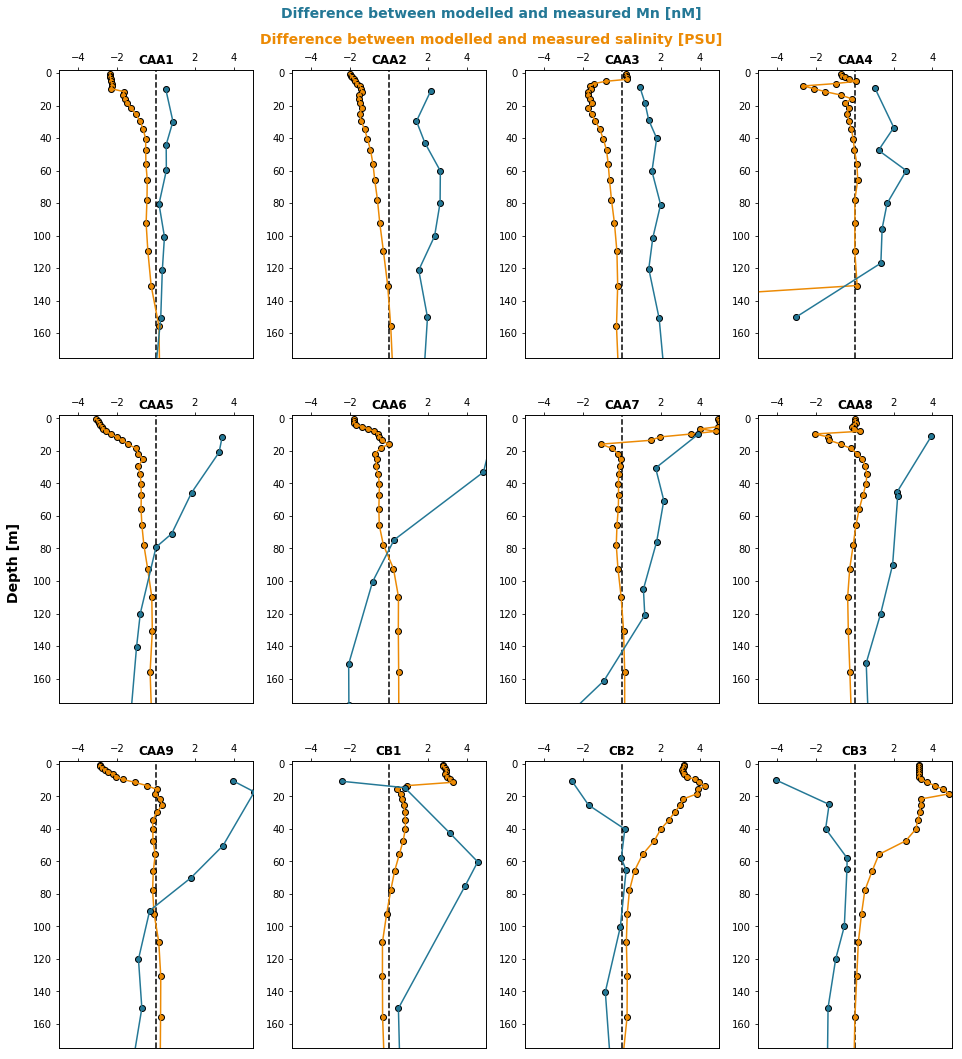

In [139]:
fig, ax = plt.subplots(3,4,figsize=(16, 18))

variable_colors = ['#ec8a04', '#247896'] # Salinity, dMn
fig.text(0.5, 0.90, 'Difference between modelled and measured salinity [PSU]', ha='center', \
         fontsize=14, color=variable_colors[0],fontweight='bold')
fig.text(0.5, 0.92, 'Difference between modelled and measured Mn [nM]', ha='center', \
         fontsize=14, color=variable_colors[1], fontweight='bold')
fig.text(0.08, 0.5, 'Depth [m]', va='center', rotation='vertical', fontsize=14, fontweight='bold')

ax1 = plot_S_dMn_diff(ax[0,0], dMn_CAA1, depth_CAA1, 'CAA1', CAA1)
ax2 = plot_S_dMn_diff(ax[0,1], dMn_CAA2, depth_CAA2, 'CAA2', CAA2)
ax3 = plot_S_dMn_diff(ax[0,2], dMn_CAA3, depth_CAA3, 'CAA3', CAA3)
ax4 = plot_S_dMn_diff(ax[0,3], dMn_CAA4, depth_CAA4, 'CAA4', CAA4)
ax5 = plot_S_dMn_diff(ax[1,0], dMn_CAA5, depth_CAA5, 'CAA5', CAA5)
ax6 = plot_S_dMn_diff(ax[1,1], dMn_CAA6, depth_CAA6, 'CAA6', CAA6)
ax7 = plot_S_dMn_diff(ax[1,2], dMn_CAA7, depth_CAA7, 'CAA7', CAA7)
ax8 = plot_S_dMn_diff(ax[1,3], dMn_CAA8, depth_CAA8, 'CAA8', CAA8)
ax9 = plot_S_dMn_diff(ax[2,0], dMn_CAA9, depth_CAA9, 'CAA9', CAA9)
ax10 = plot_S_dMn_diff(ax[2,1], dMn_CB1, depth_CB1, 'CB1', CB1)
ax11 = plot_S_dMn_diff(ax[2,2], dMn_CB2, depth_CB2, 'CB2', CB2)
ax12 = plot_S_dMn_diff(ax[2,3], dMn_CB3, depth_CB3, 'CB3', CB3)